
## About this project

We want a csv with data about most sold products in amazon, because we want to check in another websites if this products are cheaper and we can re-sell in amazon. To do this, we need specific information like the product model,brand,price, merchants, how often is sold, etc.

I will scrap in a specific main category of products (I already know some other sites selling this products with cheaper prices :D ). 

Technologies used:
- Selenium
- BeautifulSoup (utils.py)
- Pandas

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from selenium import webdriver
import pandas as pd
import time
import random
import sys
import os
import numpy as np
sys.path.append(os.path.abspath('../'))
from utils import (soup_content_from_url,
                    elements_from_soup_bestsellers_web, 
                    subcategories_from_bestsellers_web,
                    detail_dict_from_product_page,
                    load_obj,
                    save_obj)

# EDA

Estadisticos:
* Describe district
* 

In [66]:
import seaborn as sns
from matplotlib import pyplot as plt
filename = "dataframe_land.csv"
df = pd.read_csv(filename)
df.head(3)

,ref_id,neighborhood,district,province,price,currency,amount,url,description,totalArea,has_water,has_electricity,has_gas,agency,property_type,source_web,scrapped_date
0,inmueble-17-14261,Sexta seccion - Aristobulo del Valle 535,Capital,Mendoza,US$ 80.000,US$,80000.0,/17-cocucci-inmobiliaria/inmuebles/14261/ficha...,"COCUCCI INMOBILIARIA VENDE EXCELENTE LOTE, EN ...",disable,False,False,False,Cocucci Inmobiliaria,PropertyType.LAND,inmoclick,2020-07-18
1,inmueble-19352-553,25 de Mayo y Bombal,Guaymallen,Mendoza,US$ 330.000,US$,330000.0,/19352-carballo-inmobiliaria/inmuebles/553/fic...,Excelente oportunidad para inversión de desarr...,750,True,True,True,Carballo Inmobiliaria,PropertyType.LAND,inmoclick,2020-07-18
2,inmueble-17-14581,COVIARQ - Ozamis Sur 2345,Maipu,Mendoza,US$ 14.500,US$,14500.0,/17-cocucci-inmobiliaria/inmuebles/14581/ficha...,"COCUCCI INMOBILIARIA, VENDE excelente lote ubi...",350m2,False,False,False,Cocucci Inmobiliaria,PropertyType.LAND,inmoclick,2020-07-18


Metricas a calcular:
	
    Estadisticos:
		Cantidad total
		Precio promedio
		Precio mediano
		Dispersion(p99, p1, desviacion tipica)
	Abiertas por:
		* Gran Mendoza(General)
		* Departamentos(chacras separado)
		* Inmobiliaria
		* Tipo de precio (Dolar, Peso, no se sabe)
		* Tipo de inmueble (Lote, Departamento, Casa)
		* *Rango de interes*

	Rangos de interes segun inmueble:
		Lotes - Tamaño m2::
			- 0..300
			- 300..500
			- 500..1000
			- 1000..
		Departamentos - Tamaño m2:
			- 90..120
			- 120..240
			- 240..
		Casas - Superficie cubierta m2:
			- 40..60
			- 60..90
			- 90..

In [67]:
df.currency = df.currency.fillna('consultar')

In [68]:
df.district.unique()
print(f"Cantidad total de propiedades originales:{len(df)}")
gran_mendoza_list = ['Godoy Cruz', 'Maipu', 'Lujan de Cuyo', 'Las Heras', 'Capital',
       'Carrodilla', 'Guaymallen', 'Chacras de Coria',
       'Vistalba', 'Mayor Drummond', 'Perdriel', 'La Puntilla']
df = df[df.district.isin(gran_mendoza_list)]
print(f"Cantidad total de propiedades en el Gran Mendoza:{len(df)}")

Cantidad total de propiedades originales:2256
Cantidad total de propiedades en el Gran Mendoza:2137


## Tipo de inmuebles : Lotes y Terrenos

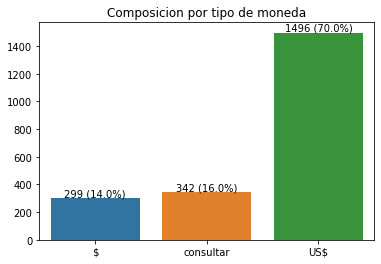

In [69]:
curr = df.groupby('currency').count().ref_id.sort_values()
share = round(curr/curr.sum()*100,1)
g = sns.barplot(x=curr.index.values,y=curr.values)
for i,row in enumerate(curr.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(i,row[1], bar_text, color='black', ha="center",va='bottom')
    
g.set_title('Composicion por tipo de moneda')
plt.show()

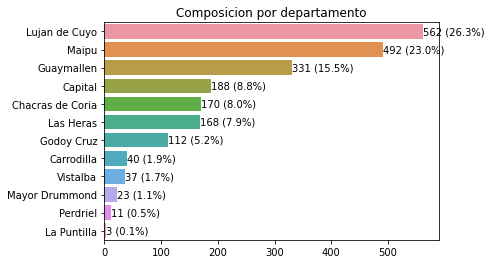

In [70]:
districts = df.groupby('district').count().ref_id.sort_values(ascending=False)
share = round(districts/districts.sum()*100,1)
g = sns.barplot(x=districts.values,y=districts.index.values)

for i,row in enumerate(districts.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(row[1],i, bar_text, color='black', ha="left",va='center',rotation=0)
g.set_title('Composicion por departamento')
plt.show()

total agencies:203


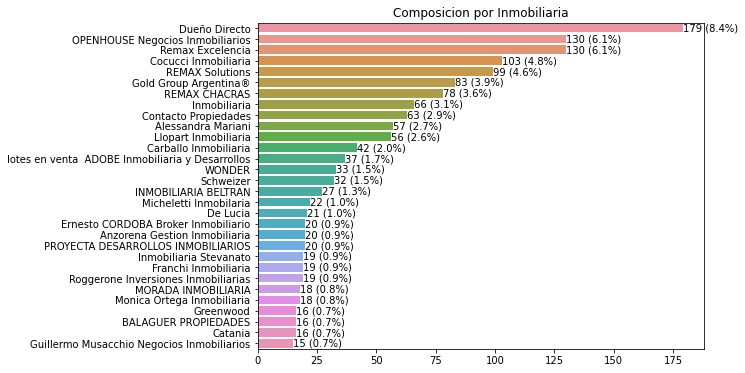

In [71]:
agency = df.groupby("agency").count().ref_id.sort_values(ascending= False)
share = round(agency/agency.sum()*100,1)
print("total agencies:"+str(len(agency)))

agency = agency.head(30)
plt.figure(figsize=(8,6))
g = sns.barplot(x=agency.values, y=agency.index.values)

for i,row in enumerate(agency.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(row[1],i, bar_text, color='black', ha="left",va='center',rotation=0)
g.set_title('Composicion por Inmobiliaria')
plt.show()

### Creating totalArea ranges

In [61]:
# Fixing types
#df = df[df['totalArea']!='disable']
df['totalArea_fixed'] = df.totalArea.str.replace('mts2','').str.replace('m2','').str.replace('m','')
df.totalArea_fixed = df.totalArea_fixed.str.strip()
def cast_to_comma(value):
    if len(value)>= 3 and value[-3]==".":
        return value.replace(".",',')
    else:
        return value
df.totalArea_fixed = df.totalArea_fixed.apply(lambda x: cast_to_comma(x))
print(df[['totalArea_fixed','totalArea']])
df.totalArea_fixed = df.totalArea_fixed.str.replace('.', '')
df.totalArea_fixed = df.totalArea_fixed.str.replace(',', '.')
df.totalArea_fixed = pd.to_numeric(df.totalArea_fixed, errors='coerce')

# Avoid totalArea less than 10 meters
df = df[df.totalArea_fixed >= 10]

     totalArea_fixed totalArea
0            disable   disable
1                750       750
2                350     350m2
3                500       500
4                623       623
...              ...       ...
2251         disable   disable
2252         disable   disable
2253         disable   disable
2254             750       750
2255           50704     50704

[2137 rows x 2 columns]


In [62]:
"""
Lotes - Tamaño m2::
        - 0..300
        - 300..500
        - 500..1000
        - 1000..
"""
        
df.loc[df.totalArea_fixed <= 300,'land_range'] = 0
df.loc[np.logical_and(df.totalArea_fixed > 300, df.totalArea_fixed <= 500),'land_range'] = 300
df.loc[np.logical_and(df.totalArea_fixed > 500, df.totalArea_fixed <= 1000),'land_range'] = 500
df.loc[df.totalArea_fixed > 1000,'land_range'] = 1000
ranges = ['0..300','300..500','500..1000','1000..']

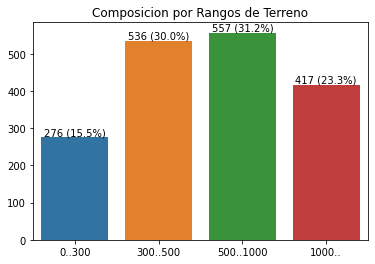

In [63]:
land_range = df.groupby('land_range').count().ref_id#.sort_values(ascending=False)
share = round(land_range/land_range.sum()*100,1)
g = sns.barplot(x=ranges, y=land_range.values)

for i,row in enumerate(land_range.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(i, row[1], bar_text, color='black', ha="center",va='bottom',rotation=0)
g.set_title('Composicion por Rangos de Terreno')
plt.show()

In [46]:
df.groupby("neighborhood").count().ref_id.to_frame().sort_values("ref_id",ascending=False)

,ref_id
neighborhood,
Palmares Valley,15
PALMARES VALLEY,11
Vieytes,8
Barrio Dalvian,7
DALVIAN,7
...,...
Calle Buena Nueva (Prof Mathus) y Moctezuma,1
"Calle Bs. As., Colonia Segovia, Guaymallen",1
Calle Brasil,1


In [47]:
df["squared_meter_amount"] = df.amount/df.totalArea_fixed

In [48]:
#district_landr = (df[df['currency']=='US$'].groupby(["district","land_range"])
#.agg({'squared_meter_amount':['mean'],'ref_id':['count']}))
pd.pivot_table(df[df['currency']=='US$'],
               values=['squared_meter_amount','ref_id'],
               index='district',
               columns='land_range',
               aggfunc={'squared_meter_amount':'mean',
                        'ref_id':'count'}).style.format("{:.1f}")

### Removing outliers

In [49]:
from scipy import stats
dolarized = df[df['currency']=='US$']
print(f"dolarized with outliers {len(dolarized)}")
z_scores = stats.zscore(dolarized.amount)
abs_z_scores = np.abs(z_scores)
dolarized = dolarized[(abs_z_scores < 3)]
print(f"dolarized without outliers {len(dolarized)}")

dolarized with outliers 1323
dolarized without outliers 1292


In [50]:
pd.pivot_table(dolarized,
               values=['squared_meter_amount','ref_id'],
               index='district',
               columns='land_range',
               aggfunc={'squared_meter_amount':'mean',
                        'ref_id':'count'}).style.format("{:.1f}")

In [16]:
lujan = df[df['currency']=='US$']
lujan = lujan[lujan.land_range==1000]
lujan = lujan[lujan['district']== 'Chacras de Coria']
lujan[['price','amount','totalArea','totalArea_fixed']].head(30)
#df[df.index==791].url.values

,price,amount,totalArea,totalArea_fixed


### Abierto por departamentos

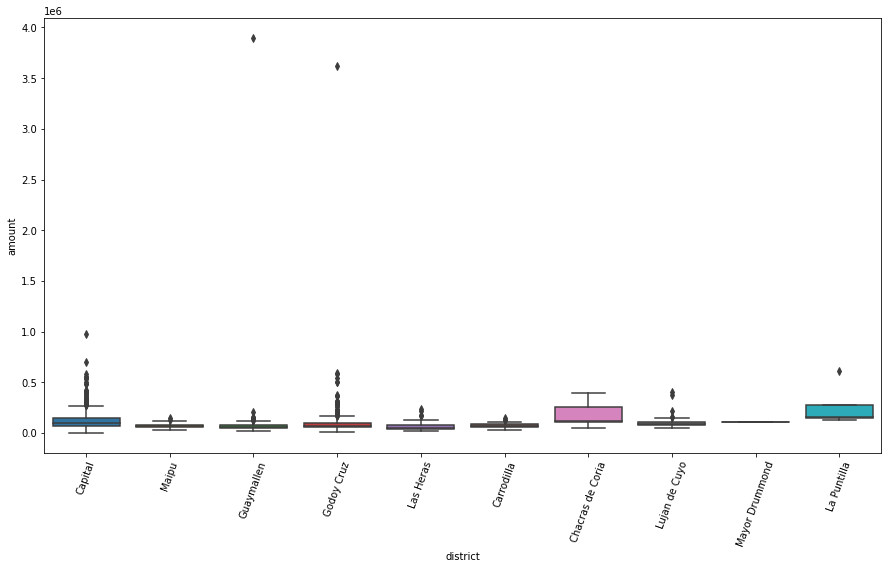

In [17]:
plt.figure(figsize=(15,8))
g = sns.boxplot(x=df[df.currency=='US$']['district'], y=df['amount'])
g.set_xticklabels(g.get_xticklabels(),rotation=70)
plt.show()

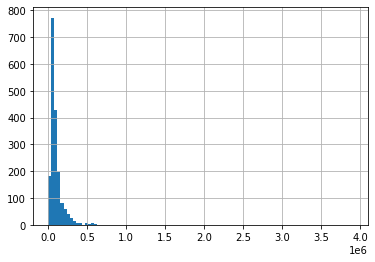

In [18]:
df[df.currency=='US$'].amount.hist(bins=100)

In [19]:
import numpy as np
#df[np.logical_and(df['amount']<30000,df['amount']>0)].sort_values(by='amount')
df[df.description.str.contains("2018")].description

144     GOLD GROUP ARGENTINA® VENDE!!\nGRAN OPORTUNIDA...
145     Gold Group Argentina® Vende!\nExclusivos dúple...
147     Gold Group Argentina® vende!!\nCómodo y prácti...
148     GOLD GROUP ARGENTINA® VENDE!!\nExtraordinario ...
150     GOLD GROUP ARGENTINA® VENDE !!! \nDEPARTAMENTO...
                              ...                        
2251    Gold Group Argentina® vende!!\nPráctico y func...
2252    Gold Group Argentina® vende!!\nCómodo y funcio...
2253    Gold Group Argentina® vende!!\nDivino departam...
2254    Gold Group Argentina® vende!!\nCómodo y dinámi...
2255    Gold Group Argentina® Vende!\nEspléndido depar...
Name: description, Length: 192, dtype: object

In [20]:
str(df[df.index==3175].url.values)

'[]'

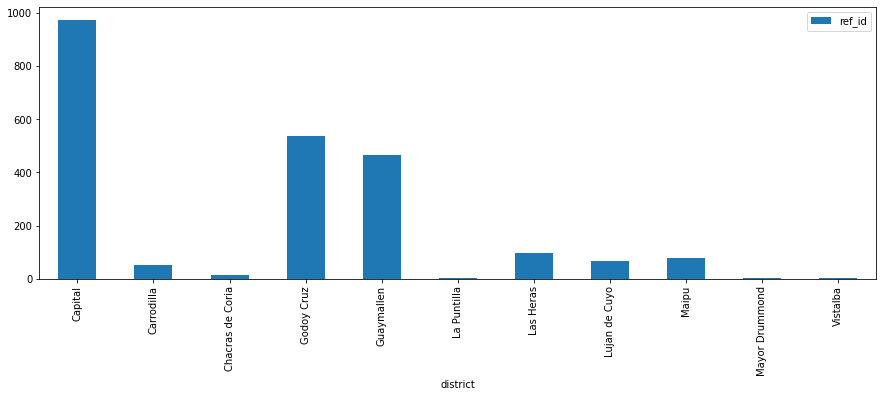

In [21]:
df.groupby('district').count().plot.bar(y='ref_id',figsize=(15,5))

In [22]:
dfdol = df[df.currency=='US$'].reset_index(drop=True)
dfdol['r_10'] = round(dfdol.recent_id/100)
h = dfdol.groupby('r_10').mean()
#pd.pivot_table(h,values,index='r_10',columns,aggfunc)

AttributeError: 'DataFrame' object has no attribute 'recent_id'

In [23]:
plt.figure(figsize=(20,8))
h.index = h.index.astype(int)
h['amount'].plot.bar()

NameError: name 'h' is not defined

<Figure size 1440x576 with 0 Axes>

KeyError: 'r_10'

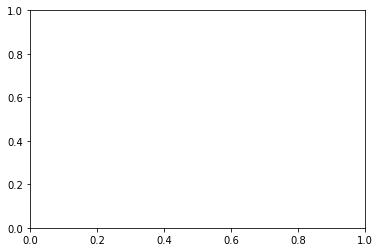

In [24]:
dfdol.plot.scatter(x='district',y='r_10',rot=90)

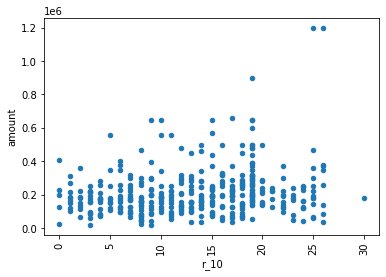

In [46]:
dfdol[dfdol.district=='Lujan de Cuyo'].plot.scatter(x='r_10',y='amount',rot=90)

In [68]:
import numpy as np
pd.set_option('display.max_columns', 30)
list(dfdol[dfdol['r_20']==3].url)

['https://www.inmoclick.com.ar/71779-greenwood/inmuebles/82/ficha/casa-en-venta-en-acceso-este-y-arturo-gonzalez?btid=2465480',
 'https://www.inmoclick.com.ar/71779-greenwood/inmuebles/84/ficha/casa-en-venta-en-juan-agustin-maza-y-azcuenaga?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1479/ficha/casa-en-venta-en-b0-privado-bucci-bandera-de-los-andes-y-rosario?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1500/ficha/casa-en-venta-en-laguna-horcones-1054-barrio-fuchs?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1508/ficha/casa-en-venta-en-vicente-gil-539?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1515/ficha/casa-en-venta-en-rufino-ortega-y-martinez-de-rozas?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1518/ficha/casa-en-venta-en-p-benegas-691?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-g

In [175]:
df2 = df[df['totalArea']!='disable']
df2.totalArea = df2.totalArea.str.replace('mts2','').str.replace('m2','').str.replace('m','')
df2.totalArea = df2.totalArea.str.strip()
df2 = df2[~df2['totalArea'].str.contains('2.852.61')]
df2.totalArea = df2['totalArea'].str.replace(',','.')

In [176]:
df2.totalArea = df2.totalArea.astype(float)

In [177]:
df2.floorArea[df2.floorArea.str.contains('\,')]

295     301,24m2
1142     57,78m2
1144     80,00m2
1204    411,00m2
1427    69,10 m2
1475    65,83 m2
1484       334,3
1675       97,15
1759    453,85m2
1760    258,32m2
1800      135,53
2006      170,47
2083    221,50m2
3038       483,6
3074      299,35
3089    313,58m2
Name: floorArea, dtype: object

In [178]:
df2 = df2[df2['floorArea']!='disable']
df2 = df2[df2['floorArea']!='140/60']
df2.floorArea = (df2.floorArea.str.replace('mts2','')
                             .str.replace('m2','')
                             .str.replace('m','')
                             .str.replace('aprox.con cocher','')
                             .str.replace('aprox.','')
                             .str.replace(',',''))
df2.floorArea = df2.floorArea.astype(float)

In [179]:
df2.loc[df2['totalArea'] >= 4000,'totalArea']=4000

In [205]:
chacras = df2[np.logical_and(df2['district']=='Chacras de Coria',df2.currency=='US$')]

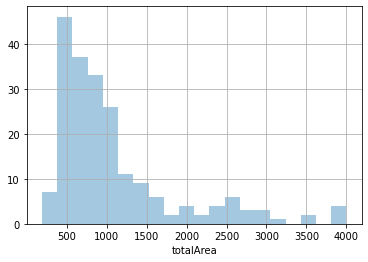

In [232]:
import seaborn as sns
g = sns.distplot(chacras.totalArea,bins=20,kde=False)
g.grid()

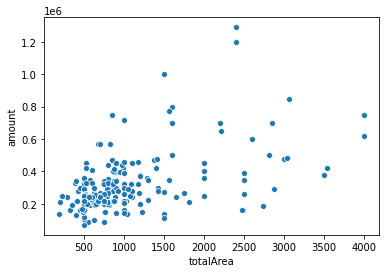

In [208]:
sns.scatterplot(x="totalArea", y="amount", data=chacras)

In [230]:
chacras['amountr'] = pd.qcut(chacras.amount,5)

/home/chanchus/developments/amz-scrapper/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


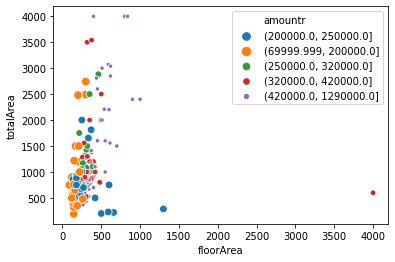

In [231]:
sns.scatterplot(x="floorArea", y="totalArea",hue="amountr", size="amountr", data=chacras)

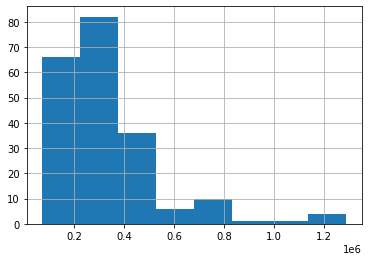

In [217]:
chacras.amount.hist(bins=8)

In [2]:
import pandas as pd

In [5]:
df1 = pd.DataFrame([['Buenos Aires',63,16,89,55],
				['Atlanta',17,29,81,17],
				['Brasil',88,82,9, 64]])
df1.columns=['Airport','A','B','C','D']
df1 = df1.set_index('Airport')

df2 = pd.DataFrame([['Buenos Aires',21,38,36],
		['Atlanta',54,88,80],
		['Brasil',44,53,53],
		['Madrid',24,58,29]])
df2.columns=['Airport','B','C','D']
df2 = df2.set_index('Airport')


,B,C,D
Airport,,,
Buenos Aires,21,38,36
Atlanta,54,88,80
Brasil,44,53,53
Madrid,24,58,29


In [6]:
df1.merge(df2, left_index=True,right_index=True)

,A,B_x,C_x,D_x,B_y,C_y,D_y
Airport,,,,,,,
Buenos Aires,63,16,89,55,21,38,36
Atlanta,17,29,81,17,54,88,80
Brasil,88,82,9,64,44,53,53
